In [1]:
!pip install --upgrade pip
!pip install --upgrade allennlp
!pip install transformers==4.3.0

     |████████████████████████████████| 595 kB 2.9 MB/s 
  Attempting uninstall: allennlp
    Found existing installation: allennlp 2.1.0
    Uninstalling allennlp-2.1.0:
      Successfully uninstalled allennlp-2.1.0
     |████████████████████████████████| 1.8 MB 2.9 MB/s 
  Attempting uninstall: transformers
    Found existing installation: transformers 4.3.3
    Uninstalling transformers-4.3.3:
      Successfully uninstalled transformers-4.3.3


In [2]:
!pip install datasets #to load xnli and mnli datasets from huggingface library
# !pip install google_trans_new
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 192 kB 2.8 MB/s 
     |████████████████████████████████| 243 kB 21.1 MB/s 
     |████████████████████████████████| 69 kB 4.5 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.56.2
    Uninstalling tqdm-4.56.2:
      Successfully uninstalled tqdm-4.56.2
     |████████████████████████████████| 55 kB 1.1 MB/s 
     |████████████████████████████████| 994 kB 3.4 MB/s 
     |████████████████████████████████| 42 kB 670 kB/s 
     |████████████████████████████████| 65 kB 1.8 MB/s 
     |████████████████████████████████| 53 kB 1.2 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=7582faa5b16ddc807f3a44a9ee3b3475a2488d93feb9205004060669acd78b51
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
import os.path
from os import path
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bt-textblob-old/back_translation_all.csv
/kaggle/input/train-val-split/train_df_sp.csv
/kaggle/input/train-val-split/validation_df_sp.csv
/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [4]:
os.environ["WANDB_API_KEY"] = "0" # to silence warning

In [5]:
from transformers import AutoTokenizer, AutoConfig, TFAutoModel    
from transformers import (XLMRobertaConfig, XLMRobertaTokenizer, TFXLMRobertaModel)            

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Dropout, Dense

from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from datasets import load_dataset, list_datasets
from tqdm import tqdm

from googletrans import Translator
# from google_trans_new import google_translator 

import time
import glob

# Resets all state generated by Keras
K.clear_session()

# For reproducibility
np.random.seed(0)

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Found TPU: ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Found TPU:  grpc://10.0.0.2:8470
Number of replicas: 8


In [7]:
# Configuration Settings
EPOCHS = 5
# BATCH_SIZE = 64
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 120
PATIENCE = 1
LEARNING_RATE = 1e-5
LOAD_XNLI = True
LOAD_MNLI = True
BACK_TRANSLATE = True
BT_DIR = '../input/bt-textblob-old' #directory containing the back translations of input training data
train_df_sp_path = '../input/train-val-split/train_df_sp.csv'
validation_df_sp_path = '../input/train-val-split/validation_df_sp.csv'

In [8]:
train_df = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test_df = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [9]:
if train_df_sp_path and validation_df_sp_path:
    # Use the same train-val split used to back translate input training data
    print ("Loading training and validation split csv files...")
    train_df = pd.read_csv(train_df_sp_path)
    validation_df = pd.read_csv(validation_df_sp_path)
else:
    # Create train-val split data
    print ("Creating training and validation split csv files...")
    # Stratify ensures that each sub-set contains approximately the same percentage of samples of each target class as the original set.
    train_df, validation_df = train_test_split(train_df, stratify=train_df.label.values, 
                                                      random_state=42, 
                                                      test_size=0.10, shuffle=True)


    train_df.reset_index(drop=True, inplace=True)
    validation_df.reset_index(drop=True, inplace=True)

#     train_df.to_csv('train_df_sp.csv', index=False)
#     validation_df.to_csv('validation_df_sp.csv', index=False)
    
    
# check the number of rows and columns in the subsets after split
print("Training data shape after split: {}".format(train_df.shape))
print("Validation data shape after split: {}".format(validation_df.shape))

Loading training and validation split csv files...
Training data shape after split: (9696, 6)
Validation data shape after split: (2424, 6)


In [10]:
def process_xnli_data(test_df, all_keys=False):   
    if all_keys:
        split = 'validation+test'
    else:
        split = 'validation'
    
    print("Loading XNLI data...")
    
    dataset = load_dataset('xnli', 'all_languages', split=split) #returns a Dataset object  
    print(dataset)
    
    entries = []   
    for entry in tqdm(dataset): 
        hypothesis_langs = entry['hypothesis']['language'] #list of 15 lang string values
        hypothesis_values = entry['hypothesis']['translation'] #list of 15 hypothesis string values

        premise_langs = list(entry['premise'].keys()) #list of 15 lang string values
        premise_values = list(entry['premise'].values()) #list of 15 premise string values

        labels = [entry['label']]*len(hypothesis_langs) #all 15 languages for the same example have same label 

        if premise_langs == hypothesis_langs: #the languages in premise and hypothesis are in same order
#             values = list(zip(premise_values, hypothesis_values, hypothesis_langs, labels))
            values = list(zip(premise_values, hypothesis_values, labels))
            entries += values

#     xnli_df = pd.DataFrame(entries, columns=['premise', 'hypothesis', 'lang_abv', 'label']) #create dataframe for each key
    xnli_df = pd.DataFrame(entries, columns=['premise', 'hypothesis', 'label']) #create dataframe for each key
    
    # Get the number of missing data points per column
    missing_values_xnli = xnli_df.isnull().sum() 

    print("Number of missing data points per column in XNLI corpus:")
    print (missing_values_xnli)

    # Drop the missing value rows
    xnli_df.dropna(axis=0, inplace=True)
    print("Total number of data examples in XNLI corpus after dropping NA values: {}".format(xnli_df.shape[0]))
    
    ################## Delete duplicate rows between test_df and xnli_df in xnli corpus #########################
    xnli_df = xnli_df.drop_duplicates() #drop duplicate rows
    print('Total number of data examples in XNLI corpus after dropping duplicate values: {}'.format(xnli_df.shape[0]))
    
    print('Test data shape: {}'.format(test_df.shape))
    test_df = test_df.drop_duplicates() #drop duplicate rows
    print('Test data shape after dropping duplicate rows: {}'.format(test_df.shape))

    df_merge = pd.merge(xnli_df, test_df, on=['premise','hypothesis'], how='inner')
    xnli_df = xnli_df.append(df_merge, ignore_index=True) 

    xnli_df['duplicated'] = xnli_df.duplicated(subset=['premise','hypothesis'], keep=False) # keep=False marks the duplicated row with a True
    xnli_df = xnli_df[~xnli_df['duplicated']] # selects only rows which are not duplicated.
    
    xnli_df.drop(['duplicated', 'id', 'lang_abv', 'language'], axis = 1, inplace=True) # remove following columns
    ################## Delete duplicate rows between test_df and xnli_df in xnli corpus #########################
    
    print("XNLI corpus shape: {}".format(xnli_df.shape))
    
    del dataset #free up space
    
    return xnli_df

In [11]:
def process_mnli_data(validation=False):
    if validation:
        keys = ['train', 'validation_matched', 'validation_mismatched']
    else:
        keys = ['train']
    
    dataset = load_dataset('glue', name='mnli') #returns a DatasetDict object
    print(dataset)
    
    df_dict = {}
    
    for key in tqdm(keys):
        print("Processing MNLI {} data...".format(key))
        
        hypothesis = dataset[key]['hypothesis']
        premise = dataset[key]['premise']
        labels = dataset[key]['label']
        
        entries = list(zip(premise, hypothesis, labels))
        
        df = pd.DataFrame(entries, columns=['premise', 'hypothesis', 'label']) #create dataframe for each key
        df_dict[key] = df
        
    if validation:
        mnli_df = pd.concat([df_dict['train'], df_dict['validation_matched'], df_dict['validation_mismatched']], ignore_index=True)
    else:
        mnli_df = df_dict['train']
    
    # Get the number of missing data points per column
    missing_values_mnli = mnli_df.isnull().sum() 

    print("Number of missing data points per column in MNLI corpus:")
    print (missing_values_mnli)

    # Drop the missing value rows from training set
    mnli_df.dropna(axis=0, inplace=True)
    print("Total number of data examples in MNLI corpus after dropping NA values: {}\n".format(mnli_df.shape[0]))
    
    del dataset #free up space
    
    return mnli_df

In [12]:
def back_translate(train_df, target_lang='fr', sample=True, num_samples_per_lang=1000):
    if sample: #sample input training data to back translate
        train_df = train_df.groupby('language', group_keys=False).apply(lambda x: x.sample(min(len(x), num_samples_per_lang))).reset_index(drop=True)  

    df_list = []
    limit_before_timeout = 100
    timeout = 5
    
    translator = Translator() 
    
    # Add functions to back translate input sentences
    def target_translate(x, target_lang):
        translation = translator.translate(x, dest=target_lang)
        return translation.text
    def source_translate(x, source_lang):
        translation = translator.translate(x, dest=source_lang) 
        return translation.text 
    
    for i in tqdm(range(len(train_df))):
        entry = train_df.loc[[i]]
        source_lang = entry.lang_abv.values.tolist()[0]
        if source_lang == 'zh':
            #print(googletrans.LANGUAGES) 
            source_lang = 'zh-cn' #'zh' not in googletrans.LANGUAGES        
        if (i!=0) and (i%limit_before_timeout == 0): #apply timeout after every 100 iterations 
            print('Iteration {} of {}'.format(i, len(train_df)))
            time.sleep(timeout)      
        # Back translate premise sentence
        entry['premise'] = entry['premise'].apply(lambda x: target_translate(x, target_lang))
#         time.sleep(0.2)
        entry['premise'] = entry['premise'].apply(lambda x: source_translate(x, source_lang))
#         time.sleep(0.2)       
        # Back translate hypothesis sentence
        entry['hypothesis'] = entry['hypothesis'].apply(lambda x: target_translate(x, target_lang))
#         time.sleep(0.2)
        entry['hypothesis'] = entry['hypothesis'].apply(lambda x: source_translate(x, source_lang))
#         time.sleep(0.2)
        df_list.append(entry)
    
    train_bt = pd.concat(df_list, ignore_index=True)
    print("Shape of back-translated training data: {}".format(train_bt.shape))
    return train_bt

In [13]:
def augment_data(df, use_xnli=True, use_mnli=True, use_bt=True, bt_dir=''):
    df_list = []  
    if use_bt:
        if path.isdir(bt_dir):
            files = glob.glob(bt_dir+'/*.csv')
            bt_list = []
            for filename in files:
                bt_list.append(pd.read_csv(filename))
            bt_df = pd.concat(bt_list, ignore_index=True)
#             bt_df.isnull().sum() # we get the number of missing values
            bt_df.dropna(inplace=True) #remove missing values
            bt_df.drop_duplicates(inplace=True) #drop duplicate rows  
            bt_df = bt_df.sample(frac=0.4) #randomly select n examples as back-translated data 
            print("Shape of back-translated training data: {}".format(bt_df.shape))
            bt_df.to_csv('back_translation_all.csv', index=False)
        else:
            bt_df = back_translate(df)
        bt_df = bt_df.drop(['id', 'lang_abv', 'language'], axis=1)
        df_list.append(bt_df)
        del bt_df #free up space 
    if use_xnli:
        xnli_df = process_xnli_data(test_df, all_keys=True)
        df_list.append(xnli_df)
        del xnli_df #free up space 
    if use_mnli:
        mnli_df = process_mnli_data(validation=False)
        df_list.append(mnli_df)
        del mnli_df #free up space
        
    train_df = df.drop(['id', 'lang_abv', 'language'], axis=1)
    
    if len(df_list) > 0: #augment data
        augmented_df = pd.concat(df_list, ignore_index=True)
        train_df = train_df.append(augmented_df, ignore_index=True) 
        
    train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle data
    print("Augmented data shape before removing duplicate rows: {}".format(train_df.shape))
    train_df.drop_duplicates(inplace=True) #drop duplicate rows
    print("Augmented data shape after removing duplicate rows: {}".format(train_df.shape))
    return train_df




train_df = augment_data(train_df, LOAD_XNLI, LOAD_MNLI, BACK_TRANSLATE, BT_DIR) 
train_df.head(100)

Shape of back-translated training data: (4778, 6)
Loading XNLI data...


  7%|▋         | 539/7500 [00:00<00:01, 5388.82it/s]

Dataset xnli downloaded and prepared to /root/.cache/huggingface/datasets/xnli/all_languages/1.1.0/51ba3a1091acf33fd7c2a54bcbeeee1b1df3ecb127fdca003d31968fa3a1e6a8. Subsequent calls will reuse this data.
Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 7500
})


100%|██████████| 7500/7500 [00:01<00:00, 5360.95it/s]


Number of missing data points per column in XNLI corpus:
premise       0
hypothesis    0
label         0
dtype: int64
Total number of data examples in XNLI corpus after dropping NA values: 112500
Total number of data examples in XNLI corpus after dropping duplicate values: 112500
Test data shape: (5195, 5)
Test data shape after dropping duplicate rows: (5195, 5)
XNLI corpus shape: (110226, 3)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mnli/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
Processing MNLI train data...


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Number of missing data points per column in MNLI corpus:
premise       0
hypothesis    0
label         0
dtype: int64
Total number of data examples in MNLI corpus after dropping NA values: 392702

Augmented data shape before removing duplicate rows: (517402, 3)
Augmented data shape after removing duplicate rows: (511528, 3)


,premise,hypothesis,label
0,"The Human Genome Project, in fact, was built u...",The Human Genome Project took over unused labs...,0
1,"If you don't want the perfume, the bottles are...",The bottles can only be bought from the perfum...,2
2,But he was puzzled.,"Anyway, he figured it out without any difficulty.",2
3,The Tropicana in Santiago de Cuba (Autopista N...,The Tropicana in Santiago de Cuba is located n...,0
4,Mrs. Inglethorp came down last.,Inglethorp failed to come down.,2
...,...,...,...
95,In addressing the consistency of these various...,"Every law change, it is important to identify ...",0
96,Там до сих пор есть укрытие и цветочный сад в ...,Люди стоят в очереди для получения возможности...,1
97,Bios Group действительно принимает участие в и...,Bios Group вложили в их создание много денег.,1
98,While the program did not fully use each of th...,The program embraced capturing design and manu...,0


In [14]:
# check the number of rows and columns in the augmented train data
print("Augmented train data shape: {}".format(train_df.shape))

Augmented train data shape: (511528, 3)


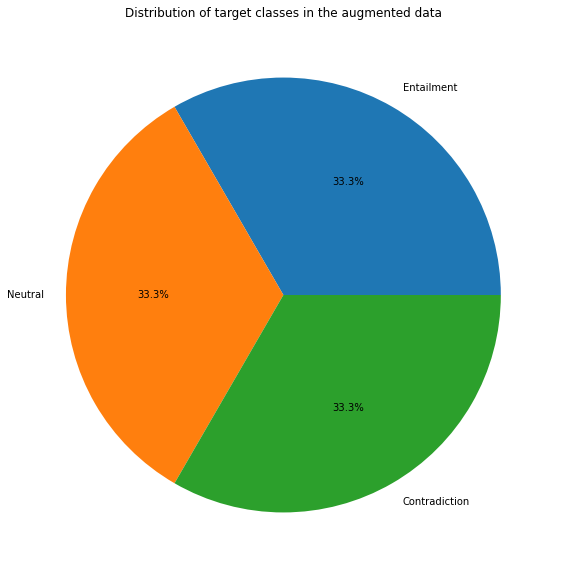

In [15]:
# check distribution of target classes in the augmented data
counts = train_df['label'].value_counts()

class_labels = ['Entailment', 'Neutral', 'Contradiction']

counts_per_class = [counts[0], counts[1], counts[2]]

plt.figure(figsize = (10,10))
plt.pie(counts_per_class, labels = class_labels, autopct = '%1.1f%%')
plt.title("Distribution of target classes in the augmented data")
plt.show()

In [16]:
PRETRAINED_MODEL_TYPES = {
    'xlmroberta': (XLMRobertaConfig, TFXLMRobertaModel, XLMRobertaTokenizer, 'jplu/tf-xlm-roberta-large')
}

config_class, model_class, tokenizer_class, model_name = PRETRAINED_MODEL_TYPES['xlmroberta']

In [17]:
# Download vocabulary from huggingface.co and cache.
# tokenizer = tokenizer_class.from_pretrained(model_name) 
tokenizer = AutoTokenizer.from_pretrained(model_name) #fast tokenizer

tokenizer

PreTrainedTokenizerFast(name_or_path='jplu/tf-xlm-roberta-large', vocab_size=250002, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [18]:
def encode(df, tokenizer, max_len=50):
    
    pairs = df[['premise','hypothesis']].values.tolist() #shape=[num_examples]
    
    print ("Encoding...")
    encoded_dict = tokenizer.batch_encode_plus(pairs, max_length=max_len, padding=True, truncation=True, 
                                               add_special_tokens=True, return_attention_mask=True)
    print ("Complete")
    
    input_word_ids = tf.convert_to_tensor(encoded_dict['input_ids'], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.convert_to_tensor(encoded_dict['attention_mask'], dtype=tf.int32) #shape=[num_examples, max_len]
    
    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask}    
    
    return inputs

In [19]:
train_input = encode(train_df, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [20]:
train_input['input_word_ids'].shape #[num_examples, max_len]
train_input['input_mask'].shape #[num_examples, max_len]

TensorShape([511528, 120])

In [21]:
validation_input = encode(validation_df, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [22]:
validation_input['input_word_ids'].shape #[num_examples, max_len]
validation_input['input_mask'].shape #[num_examples, max_len]

TensorShape([2424, 120])

In [23]:
# from keras.layers.normalization import BatchNormalization

def build_model(model_name, max_len=50):
    
    tf.random.set_seed(1234)
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    
    # The bare XLM-RoBERTa Model transformer outputting raw hidden-states without any specific head on top.
    base_model = model_class.from_pretrained(model_name)
#     base_model = TFAutoModel.from_pretrained(model_name)
    
#     # Extract pretrained embedding vectors
#     embedding = base_model([input_word_ids, input_mask])[0] # shape=(batch_size, max_len, embed_size)
#     # We pass the embedding vectors of only the 'cls' token (at index=0) to the dense layer
#     sequence_output = embedding[:,0,:] #shape=(batch_size, embed_size)

    
    ### pooler_output contains the hidden representation of just the ‘[CLS]’ token after additionally being passed to a fully connected layer with tanh activation function.
    ### output = base_model([input_word_ids, input_mask], training=False) # output from xlmroberta model
    output = base_model([input_word_ids, input_mask]) # output from xlmroberta model
    sequence_output = output.pooler_output #shape: [batch_size, embed_size]
    ### sequence_output = Dropout(0.3)(sequence_output) #add dropout
    
#     # Add an LSTM layer to get sentence embeddings
#     sequence_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, dropout=0.3, recurrent_dropout=0.3))(embedding) # shape=(batch_size, output_size) 
# #     sequence_output = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(150, dropout=0.3, recurrent_dropout=0.3))(embedding) # shape=(batch_size, output_size) 
    
#     # Add a fully-connected layer
#     sequence_output = tf.keras.layers.Dense(300, activation="relu")(sequence_output)
#     sequence_output = BatchNormalization()(sequence_output)
#     sequence_output = tf.keras.layers.Dropout(0.3)(sequence_output) 
    
    # Add a classification layer
    output = Dense(units=3, activation="softmax", name='output')(sequence_output)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = build_model(model_name, MAX_LEN)
    model.summary()

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
output (Dense)                  (None, 3)            3075        tfxlm_roberta_model[0][1]    

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath='best_checkpoint.hdf5'

# Save the best model during validation and bail out of training early if we're not improving
# callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)]
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)]
# callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE)]


train_history = model.fit(x=train_input, y=train_df.label.values, validation_data=(validation_input, validation_df.label.values), epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


3997/3997 [==============================] - 1187s 267ms/step - loss: 0.5353 - accuracy: 0.7637 - val_loss: 0.2883 - val_accuracy: 0.8923

Epoch 00001: val_loss improved from inf to 0.28832, saving model to best_checkpoint.hdf5
Epoch 2/5
3997/3997 [==============================] - 979s 245ms/step - loss: 0.2852 - accuracy: 0.8944 - val_loss: 0.2209 - val_accuracy: 0.9266

Epoch 00002: val_loss improved from 0.28832 to 0.22086, saving model to best_checkpoint.hdf5
Epoch 3/5
3997/3997 [==============================] - 979s 245ms/step - loss: 0.2102 - accuracy: 0.9238 - val_loss: 0.1989 - val_accuracy: 0.9344

Epoch 00003: val_loss improved from 0.22086 to 0.19892, saving model to best_checkpoint.hdf5
Epoch 4/5
3997/3997 [==============================] - 978s 245ms/step - loss: 0.1653 - accuracy: 0.9405 - val_loss: 0.2073 - val_accuracy: 0.9369

Epoch 00004: val_loss did not improve from 0.19892
Epoch 00004: early stopping


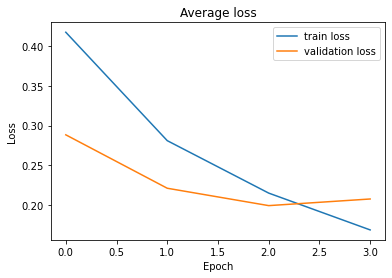

In [26]:
# plot training history
plt.plot(train_history.history['loss'], label='train loss')
plt.plot(train_history.history['val_loss'], label='validation loss')
plt.title('Average loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_history.png')

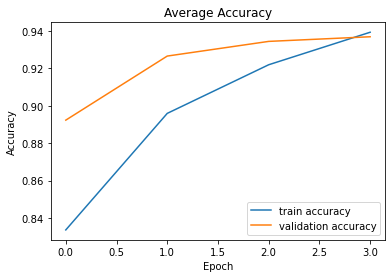

In [27]:
# plot training history
plt.plot(train_history.history['accuracy'], label='train accuracy')
plt.plot(train_history.history['val_accuracy'], label='validation accuracy')
plt.title('Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_history.png')
plt.show()

In [28]:
## The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

In [29]:
print("Number of examples in Test data: {}".format(test_df.shape[0]))

test_df.head()

Number of examples in Test data: 5195


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [30]:
test_input = encode(test_df, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [31]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
# predictions = predictions[:test.shape[0]]

In [32]:
submission = test_df.id.copy().to_frame()
submission['prediction'] = predictions

submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1


In [33]:
submission.to_csv("submission.csv", index = False)

In [34]:
# save validation predictions to check outputs against gold-label and include results in capstone report
val_predictions = [np.argmax(i) for i in model.predict(validation_input)]
validation_df['prediction'] = val_predictions
validation_df.to_csv("validation_predictions.csv", index=False)

In [35]:
validation_df.head()

,id,premise,hypothesis,lang_abv,language,label,prediction
0,e591a77c6c,ดังนั้น สำนักงานตัวแทนสหภาพต้องการคิดทบทวนการป...,ตัวแทนของรัฐบาลกลางมีทรัพยากรมนุษย์ที่เพียงพอ,th,Thai,2,2
1,b8198e0a5d,and uh as a matter of fact he's a draft dodger,"They dodged the draft, I'll have you know.",en,English,0,0
2,6c46429835,"Шефе, той беше като човек с раздвоена личност.","Шефът ми беше или наистина щастлив, или наисти...",bg,Bulgarian,1,1
3,b9fcf02f32,"Nichts kommt von nichts, behauptete Lukrez vor...",Die Argumente von Lecretius wurden von Tautolo...,de,German,2,2
4,b82c59d12d,مالی سال 2000 کانگریس اور امریکی ٹیکس دہندہ کے...,2000 اب تک کا سب سے برا سال تھا۔,ur,Urdu,2,2


In [36]:
from sklearn.metrics import accuracy_score
true_labels = validation_df.label.values.tolist()
accuracy_score(y_true=true_labels, y_pred=val_predictions)

0.9344059405940595

In [37]:
# save xnli test-set predictions to check outputs against gold-label and include results in capstone report
xnli_test_df = process_xnli_data(test_df, all_keys=True)
xnli_test_df = xnli_test_df.sample(frac=1).reset_index(drop=True) #shuffle and take n% of data to generate predictions
print ("XNLI test data shape: {}".format(xnli_test_df.shape))
xnli_test_input = encode(xnli_test_df, tokenizer=tokenizer, max_len=MAX_LEN)
xnli_test_predictions = [np.argmax(i) for i in model.predict(xnli_test_input)]
xnli_test_df['prediction'] = xnli_test_predictions
xnli_test_df.to_csv("xnli_test_predictions.csv", index=False)

Loading XNLI data...


  5%|▌         | 411/7500 [00:00<00:01, 4105.17it/s]

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 7500
})


100%|██████████| 7500/7500 [00:01<00:00, 4295.31it/s]


Number of missing data points per column in XNLI corpus:
premise       0
hypothesis    0
label         0
dtype: int64
Total number of data examples in XNLI corpus after dropping NA values: 112500
Total number of data examples in XNLI corpus after dropping duplicate values: 112500
Test data shape: (5195, 5)
Test data shape after dropping duplicate rows: (5195, 5)
XNLI corpus shape: (110226, 3)
XNLI test data shape: (110226, 3)
Encoding...
Complete


In [38]:
xnli_test_df.head()

,premise,hypothesis,label,prediction
0,و أه لكن جاءت فجأة من مكان ما لا أعرف من أين ج...,لا أعلم من أين تأتي لكنها سريعة.,0,0
1,ไบรอันในพลาโน เท็กซัส วันนี้คุณเป็นอย่างไรบ้าง,พลาโน เท็กซัสเป็นสถานที่ที่ยอดเยี่ยม,1,1
2,"लाँरेन्स सिंगलटन, एक कुख्यात बलात्कारी जो अपने...",पीड़ितों के टुकड़ों को हैक करने के बाद उसे कुड...,1,1
3,le dernier contrat qui a été adjugé Virginie a...,Les contrats ont tous été signés sans problème.,2,2
4,और आपको यह जानकर बहुत संतोष होगा कि आपके सहयोग...,हर किसी को आपके भयानक फैसले को अनुकरण करने से ...,2,2


In [39]:
from sklearn.metrics import accuracy_score
true_labels = xnli_test_df.label.values.tolist()
accuracy_score(y_true=true_labels, y_pred=xnli_test_predictions)

0.9880881098833306